In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install -q kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
import torch
torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device(type='cuda', index=0)

In [7]:
!kaggle datasets download -d dansbecker/food-101

100% 9.37G/9.38G [01:33<00:00, 202MB/s]
100% 9.38G/9.38G [01:33<00:00, 108MB/s]


In [8]:
! unzip -o food-101.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: food-101/food-101/images/tacos/1030289.jpg  
  inflating: food-101/food-101/images/tacos/1033196.jpg  
  inflating: food-101/food-101/images/tacos/1036030.jpg  
  inflating: food-101/food-101/images/tacos/1042175.jpg  
  inflating: food-101/food-101/images/tacos/1044043.jpg  
  inflating: food-101/food-101/images/tacos/1058697.jpg  
  inflating: food-101/food-101/images/tacos/1059239.jpg  
  inflating: food-101/food-101/images/tacos/1059326.jpg  
  inflating: food-101/food-101/images/tacos/1066762.jpg  
  inflating: food-101/food-101/images/tacos/1070967.jpg  
  inflating: food-101/food-101/images/tacos/1073468.jpg  
  inflating: food-101/food-101/images/tacos/1075296.jpg  
  inflating: food-101/food-101/images/tacos/1085243.jpg  
  inflating: food-101/food-101/images/tacos/108529.jpg  
  inflating: food-101/food-101/images/tacos/1086014.jpg  
  inflating: food-101/food-101/images/tacos/108945.jpg  
  infl

In [9]:
!pip3 install timm albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.5 MB/s eta 0:00:00


In [10]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random
import matplotlib.image as mpimg
from tqdm import tqdm
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim


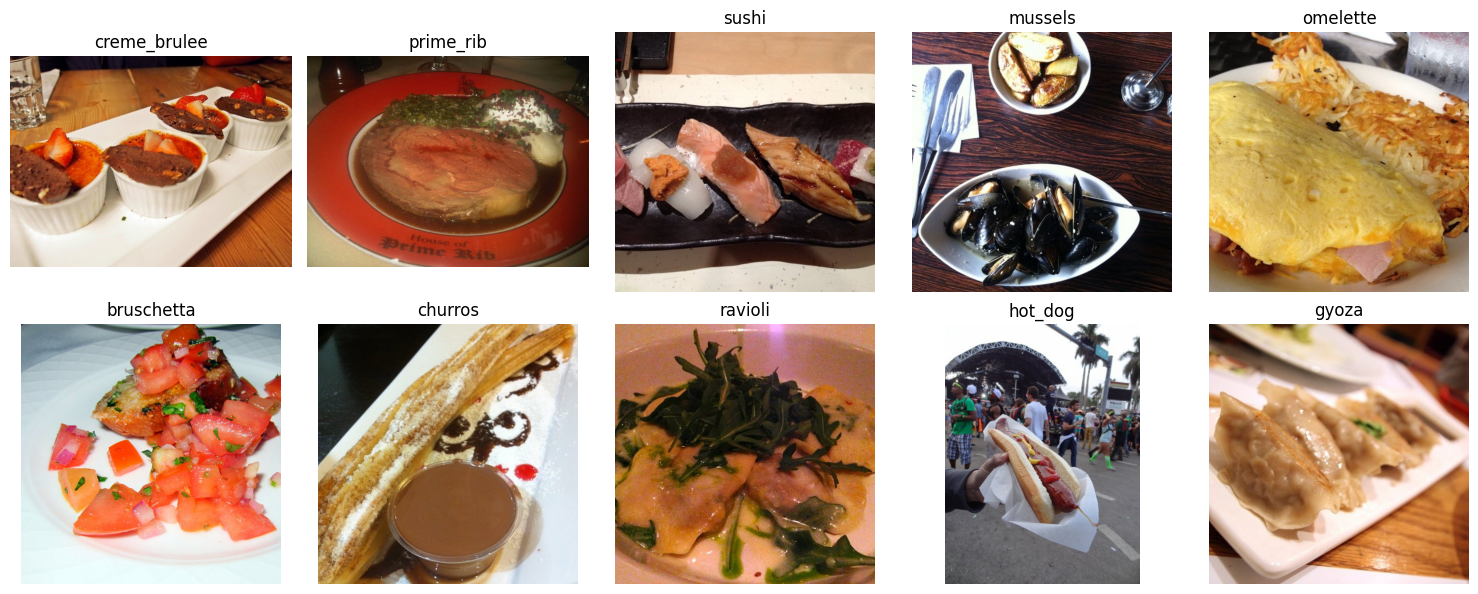

In [11]:
root_dir = 'food-101/food-101/images'
# Define the directory containing the folders of classes

# Get the list of class folders
class_folders = os.listdir(root_dir)

# Select the first 20 class folders
class_folders = class_folders[:10]

# Randomly select one image from each class folder
selected_images = []
for class_folder in class_folders:
    class_path = os.path.join(root_dir, class_folder)
    image_files = os.listdir(class_path)
    random_image = random.choice(image_files)
    image_path = os.path.join(class_path, random_image)
    selected_images.append((class_folder, image_path))

# Plot the selected images
num_images = len(selected_images)
num_cols = 5
num_rows = (num_images + num_cols - 1) // num_cols

plt.figure(figsize=(15, 3 * num_rows))
for i, (class_name, image_path) in enumerate(selected_images):
    plt.subplot(num_rows, num_cols, i + 1)
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

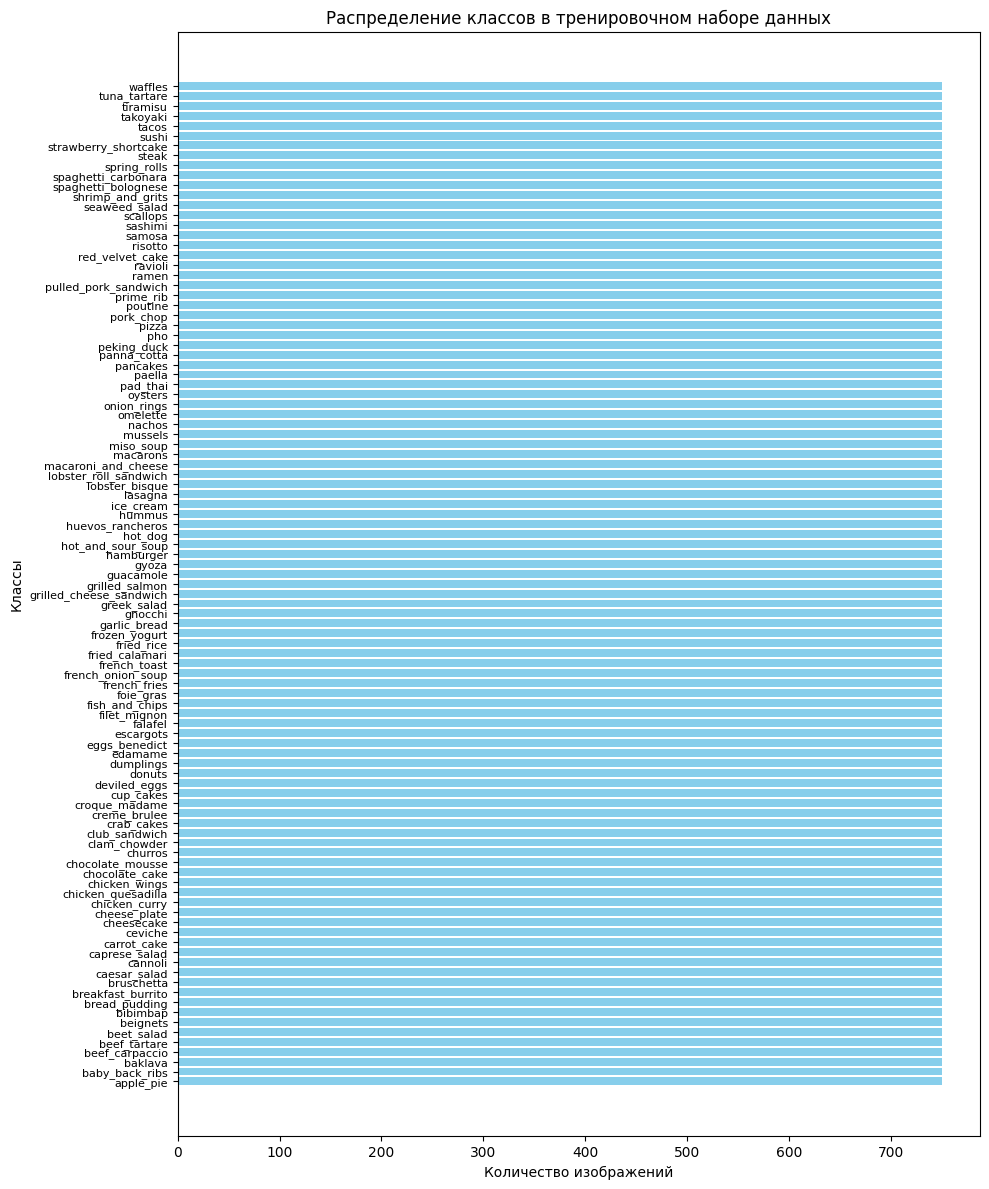

In [ ]:
# Путь к файлу train.txt
train_file = "food-101/food-101/meta/train.txt"

# Читаем train.txt и подсчитываем количество изображений для каждого класса
class_counts = {}
with open(train_file, 'r') as f:
    for line in f:
        class_name = line.split('/')[0]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1

# Отображаем распределение классов в виде горизонтальной столбчатой диаграммы с увеличенным межстрочным отступом
plt.figure(figsize=(10, 12))
plt.barh(list(class_counts.keys()), list(class_counts.values()), color='skyblue')
plt.xlabel('Количество изображений')
plt.ylabel('Классы')
plt.title('Распределение классов в тренировочном наборе данных')

plt.yticks(fontsize=8, rotation=0, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
import os
import cv2
import numpy as np

def calculate_class_means(data_folder, class_names, image_paths_dict):
    """
    Calculate mean RGB values for each class in the dataset separately for train and test sets.
    """
    class_means = {}

    for class_name in class_names:
        class_folder = os.path.join(data_folder, class_name)

        train_image_paths = image_paths_dict[class_name]['train']
        test_image_paths = image_paths_dict[class_name]['test']

        train_mean = calculate_rgb_mean(train_image_paths)
        test_mean = calculate_rgb_mean(test_image_paths)

        class_means[class_name] = {'train': train_mean, 'test': test_mean}

    return class_means

def calculate_rgb_mean(image_paths):
    """
    Calculate mean RGB values for a list of images.
    """
    total_pixels = 0
    running_sum = np.zeros(3)

    for image_path in image_paths:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        total_pixels += image.size / 3
        running_sum += np.sum(image, axis=(0, 1))

    mean = running_sum / total_pixels
    return mean

# Paths to the folder containing the dataset and the text files with image names
data_folder = 'food-101/food-101/images'
train_txt = 'food-101/food-101/meta/train.txt'
test_txt = 'food-101/food-101/meta/test.txt'

# Read image names from the train and test text files
def read_image_paths(txt_file):
    with open(txt_file, 'r') as f:
        image_names = [name.strip() + '.jpg' for name in f.readlines()]
    return [os.path.join(data_folder, name) for name in image_names]

train_image_paths_dict = {}
test_image_paths_dict = {}

with open(train_txt, 'r') as f:
    for line in f:
        class_name, image_name = line.strip().split('/')
        train_image_paths_dict.setdefault(class_name, []).append(os.path.join(data_folder, line.strip() + '.jpg'))

with open(test_txt, 'r') as f:
    for line in f:
        class_name, image_name = line.strip().split('/')
        test_image_paths_dict.setdefault(class_name, []).append(os.path.join(data_folder, line.strip() + '.jpg'))

# Get the list of class names from the subdirectories
class_names = os.listdir(data_folder)

# Calculate mean RGB values for each class
class_means = calculate_class_means(data_folder, class_names, {'train': train_image_paths_dict, 'test': test_image_paths_dict})

# Print the mean RGB values for each class for train and test sets
for class_name, mean_dict in class_means.items():
    print(f"Class: {class_name}")
    print(f"Train Mean RGB: {mean_dict['train']}")
    print(f"Test Mean RGB: {mean_dict['test']}")
    print()


KeyError: 'dumplings'

In [ ]:
for class_name, count in class_counts.items():
    print(f"class_name: {class_name}, count: {count}")

class_name: apple_pie, count: 750
class_name: baby_back_ribs, count: 750
class_name: baklava, count: 750
class_name: beef_carpaccio, count: 750
class_name: beef_tartare, count: 750
class_name: beet_salad, count: 750
class_name: beignets, count: 750
class_name: bibimbap, count: 750
class_name: bread_pudding, count: 750
class_name: breakfast_burrito, count: 750
class_name: bruschetta, count: 750
class_name: caesar_salad, count: 750
class_name: cannoli, count: 750
class_name: caprese_salad, count: 750
class_name: carrot_cake, count: 750
class_name: ceviche, count: 750
class_name: cheesecake, count: 750
class_name: cheese_plate, count: 750
class_name: chicken_curry, count: 750
class_name: chicken_quesadilla, count: 750
class_name: chicken_wings, count: 750
class_name: chocolate_cake, count: 750
class_name: chocolate_mousse, count: 750
class_name: churros, count: 750
class_name: clam_chowder, count: 750
class_name: club_sandwich, count: 750
class_name: crab_cakes, count: 750
class_name: cre

In [ ]:
#create Dataset
import os
import torch
from torch.utils.data import Dataset

class FoodDataset(Dataset):
    def __init__(self, root_dir, classes_file, labels_file, data_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels_dict = {}

        with open(classes_file, 'r') as f:
            class_names = [line.strip() for line in f.readlines()]

        with open(labels_file, 'r') as f:
            labels = range(0, len(f.readlines()))

        for class_name, label in zip(class_names, labels):
            key = class_name
            self.labels_dict[key] = label

        with open(data_file, 'r') as f:
            self.data = [line.strip() for line in f.readlines()]


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data[idx] + '.jpg')
        label = self.labels_dict[self.data[idx].split("/")[0]]
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, label


In [ ]:
classes = 101
img_size = (224, 224)
batch_size = 128
num_workers = 12
pin_memory = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

root_dir = 'food-101/food-101/images'
classes_file = 'food-101/food-101/meta/classes.txt'
labels_file = 'food-101/food-101/meta/labels.txt'
train_file = 'food-101/food-101/meta/train.txt'
test_file = 'food-101/food-101/meta/test.txt'

transform_train = A.Compose([
    A.ColorJitter(p=0.2),
    A.Blur(blur_limit=7, p=0.3),
    A.ShiftScaleRotate(p=0.2),
    A.RandomToneCurve(scale=0.1, always_apply=False, p=0.25),
    A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, interpolation=1, border_mode=4, p=0.2),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.2),
    A.Resize(*img_size),
    A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])


transform_val = A.Compose([
    A.Resize(*img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

train_dataset = FoodDataset(root_dir, classes_file, labels_file, train_file, transform_train)
test_dataset = FoodDataset(root_dir, classes_file, labels_file, test_file, transform_val)


train_loader = DataLoader(train_dataset, shuffle=True,
                          batch_size=batch_size,
                          num_workers=num_workers,
                          pin_memory=pin_memory
                          )
val_loader = DataLoader(test_dataset, shuffle=False,
                        batch_size=batch_size,
                        num_workers=num_workers,
                        pin_memory=pin_memory
                        )

model = timm.create_model('resnet18', pretrained=True, num_classes=classes)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be a

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [ ]:
#set optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                        factor=0.5, patience=5)


In [ ]:
#set criteria
criterion = nn.CrossEntropyLoss()

In [ ]:

def train_one_epoch(model, criterion, optimizer, scheduler, train_loader, device):
    model.train()  # Set the model to train mode

    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with tqdm(train_loader, unit="batch") as tepoch:
        tepoch.set_description("Training")
        for inputs, targets in tepoch:
            inputs = inputs.to(device)  # Move inputs to the GPU if available
            targets = targets.to(device)  # Move targets to the GPU if available

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()


            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == targets).sum().item()
            total_samples += targets.size(0)

            tepoch.set_postfix(loss=running_loss / total_samples, accuracy=correct_predictions / total_samples)
        scheduler.step(loss)
    return running_loss / total_samples, correct_predictions / total_samples

In [ ]:
def train_and_test(model, criterion, optimizer, scheduler, train_loader, test_loader, num_epochs, device):
    save_path = "best_w.pt"
    best_accuracy=0.0
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(model, criterion, optimizer, scheduler, train_loader, device)
        test_loss, test_accuracy = test_one_epoch(model, criterion, test_loader, device)

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

        if test_accuracy > best_accuracy:
            torch.save(model.state_dict(), save_path)
            best_accuracy = test_accuracy
            print("Best model saved.")

In [ ]:
ckpt = "best-weights.pth"
model = timm.create_model('resnet18', num_classes=101, pretrained=False).eval()
checkpoint = torch.load(ckpt, map_location='cpu')
model.load_state_dict(checkpoint)
model = model.to(device)


In [ ]:
def calculate_top1_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode

    correct_predictions = 0
    total_samples = 0

    with torch.no_grad(), tqdm(data_loader, unit="batch") as tepoch:  # Disable gradient calculation during evaluation
        tepoch.set_description("Testing")
        for inputs, targets in tepoch:
            inputs = inputs.to(device)  # Move inputs to the GPU if available
            targets = targets.to(device)  # Move targets to the GPU if available

            # Forward pass
            outputs = model(inputs)

            # Calculate top-1 accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == targets).sum().item()
            total_samples += targets.size(0)

            tepoch.set_postfix(accuracy=correct_predictions / total_samples)

    return correct_predictions / total_samples

In [ ]:
def calculate_class_accuracy(model, data_loader, device):
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to store correct predictions and total predictions for each class
    num_classes = len(data_loader.dataset.classes)
    class_correct = [0 for _ in range(num_classes)]
    class_total = [0 for _ in range(num_classes)]

    # Move model to the specified device
    model.to(device)

    # Disable gradient computation for efficiency
    with torch.no_grad():
        # Iterate through the data loader
        for images, labels in data_loader:
            # Move images and labels to the specified device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Calculate accuracy for each class
            for i in range(len(labels)):
                label = labels[i]
                prediction = predicted[i]
                if prediction == label:
                    class_correct[label] += 1
                class_total[label] += 1

    # Calculate accuracy for each class and store in a dictionary
    class_accuracy = {}
    for i in range(num_classes):
        if class_total[i] > 0:
            class_acc = 100 * class_correct[i] / class_total[i]
            class_accuracy[data_loader.dataset.classes[i]] = class_acc

    return class_accuracy

In [ ]:
calculate_top1_accuracy(model, val_loader, device)

Testing:   0%|          | 0/198 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Testing: 100%|██████████| 198/198 [02:16<00:00,  1.46batch/s, accuracy=0.73]


0.730059405940594

In [ ]:
ckpt = "resnet50d_best_w.pt"
model = timm.create_model('resnet50d', num_classes=101, pretrained=False).eval()
checkpoint = torch.load(ckpt, map_location='cpu')
model.load_state_dict(checkpoint)
model = model.to(device)

In [ ]:
calculate_top1_accuracy(model, val_loader, device)

Testing: 100%|██████████| 198/198 [02:22<00:00,  1.39batch/s, accuracy=0.828]


0.8276435643564356

In [ ]:
ckpt = "best_w.pt"
model = timm.create_model('tf_efficientnetv2_s.in1k', num_classes=101, pretrained=False).eval()
checkpoint = torch.load(ckpt, map_location='cpu')
model.load_state_dict(checkpoint)
model = model.to(device)

In [ ]:
calculate_top1_accuracy(model, val_loader, device)

Testing: 100%|██████████| 198/198 [02:21<00:00,  1.40batch/s, accuracy=0.883]


0.8825346534653465